In [1]:
import logging
import os
import sys
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import yaml
from tqdm.auto import trange

logging.basicConfig(level=logging.INFO)

try:
    from google.colab import drive
except ImportError:
    sys.path.append(os.path.realpath(".."))
else:
    drive.mount("/content/drive")
    sys.path.append("/content/drive/MyDrive/ecg-reconstruction/src")

from ecg.trainer import Trainer
from ecg.parameter import evaluate_synthesized_ecg_parameters
from ecg.util.path import resolve_path

2023-07-12 19:27:12.532614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 19:27:12.600877: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


INFO:root:Experiment: UNet/20230712-1232


  0%|          | 0/100 [00:00<?, ?it/s]

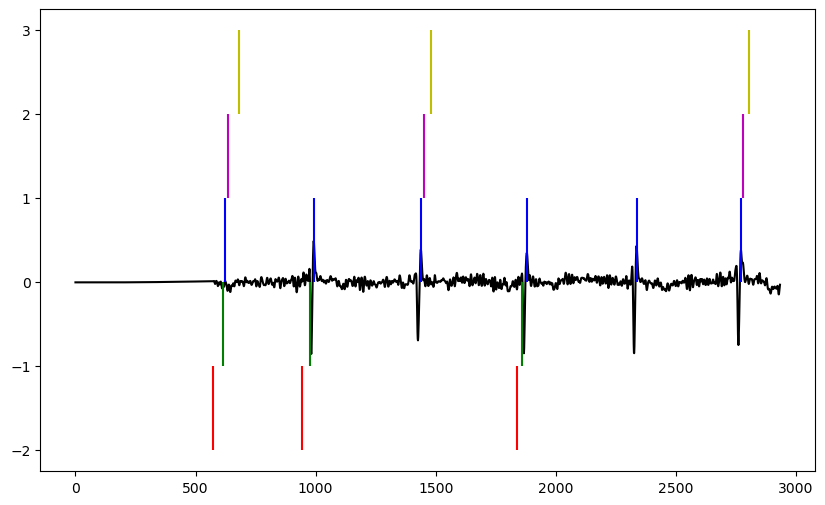

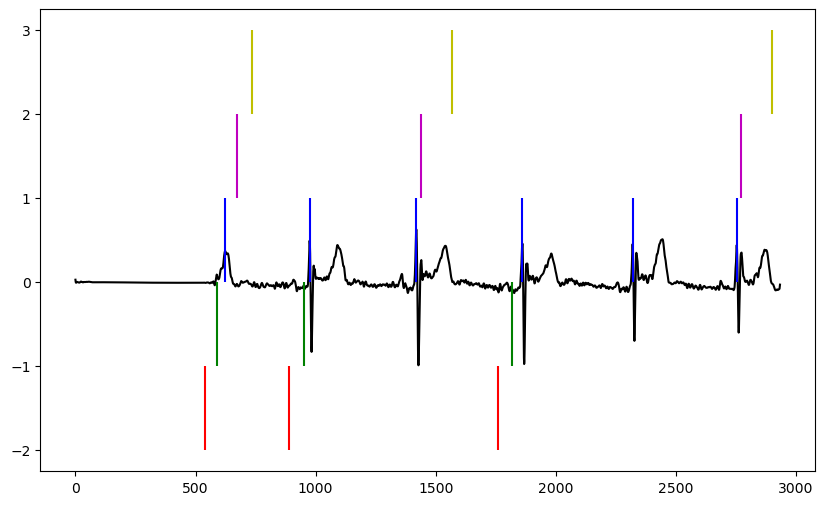

RuntimeError: 

In [2]:
# This is a list of trained models. Each item in the list has 2 elements: model folder
# name and version. If version is None, the latest version will be used. Otherwise,
# please specify the version.
experiment_list: list[tuple[str, Optional[str]]] = [
    ("UNet", "20230712-1232"),
]

for experiment_name, version in experiment_list:
    checkpoint_dir = resolve_path("src/checkpoints") / experiment_name
    if version is None:
        version = (checkpoint_dir / "latest").read_text().strip()
    checkpoint_dir /= version

    with open(checkpoint_dir / "trainer_config.yaml", encoding="utf-8") as config_file:
        config = yaml.load(config_file, Loader=yaml.Loader)
    # Disable the optimizer and learning-rate scheduler.
    config["optimizer"] = None
    config["lr_scheduler"] = None
    # Replace validation.hdf5 with test.hdf5.
    hdf5_filename = Path(config["dataset"]["eval"]["hdf5_filename"])
    hdf5_filename = hdf5_filename.parent / "test.hdf5"
    config["dataset"]["eval"]["hdf5_filename"] = hdf5_filename
    # config["dataset"]["common"]["include_filtered_signal"] = True

    trainer = Trainer(config)
    # Load only the state dictionary of the reconstructor.
    trainer.reconstructor.load_state_dict(
        torch.load(checkpoint_dir / (checkpoint_dir / "best").read_text().strip())[
            "reconstructor"
        ]
    )

    experiment = f"{experiment_name}/{version}"
    logging.info("Experiment: %s", experiment)

    aggregate_diff_dict = {}
    # for i in trange(len(trainer.eval_dataset)):
    for i in trange(100):
        diff_dict = evaluate_synthesized_ecg_parameters(
            trainer.reconstructor, trainer.eval_dataset, i, debug=True
        )
        for diff_key, diff_value in diff_dict.items():
            aggregate_diff_dict.setdefault(diff_key, []).extend(diff_value)
    logging.info(
        "Ratio of matches (higher is better): %s",
        {
            diff_key: 1 - np.isnan(diff_value).mean()
            for diff_key, diff_value in aggregate_diff_dict.items()
        },
    )
    logging.info(
        "Average difference between matches (lower is better): %s",
        {
            diff_key: np.nanmean(np.abs(diff_value))
            for diff_key, diff_value in aggregate_diff_dict.items()
        },
    )